In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

%matplotlib inline
np.random.seed(42)
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
   
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [3]:
train_nsl_kdd_dataset_path = "NSL_KDD_Dataset/KDDTrain+.txt"
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

categoricalColumns = col_names[[1,2,3]]
binaryColumns = col_names[[6, 11, 13, 14, 20, 21]]
numericColumns = col_names[list(set(range(41)) - set([1,2,3]) - set([6, 11, 13, 14, 20, 21]))]

train = pd.read_csv(train_nsl_kdd_dataset_path, header=None)
train.drop([42], 1, inplace=True)
train.columns = col_names

testData = pd.read_csv("NSL_KDD_Dataset/KDDTest+.txt", header=None)

testData.drop([42], 1, inplace=True)
testData.columns = col_names

mergedDataSet = pd.concat([train, testData]).reset_index(drop=True)
mergedDataSet.shape

(148517, 42)

In [4]:
# Performing all the encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = LabelEncoder()
#
def encodeCategorical(ser):
    return enc.fit_transform(ser)

mergedDataSet['service'] = encodeCategorical(mergedDataSet['service'])
mergedDataSet['flag'] = encodeCategorical(mergedDataSet['flag'])
mergedDataSet = pd.get_dummies(mergedDataSet, columns=['protocol_type'])
mergedDataSet['labelsMapped'] = mergedDataSet['labels'].map(lambda x: attack_dict[x])

In [5]:
testDataSet = mergedDataSet.loc[train.shape[0]:,:]
trainDataSet = mergedDataSet.loc[:train.shape[0], :]

In [6]:
#binaryColumns = list(binaryColumns) + list(categoricalColumns[1:]) + [u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp']
import sys
from collections import OrderedDict
e = sys.float_info.epsilon
def calAttributeRatio(df, numericColumns,binaryColumns):
    denom = {}
    ar = {}
    for col in numericColumns:
        denom[col] = df[col].mean();

    for col in numericColumns:
        ar[col] = df.fillna(value=0.0).groupby('labelsMapped')[[col]].mean().max().values[0]/(denom[col])

    def test_sum(series):
        return (series.sum()/(len(series)-series.sum()+e))
    for col in binaryColumns:
        groups = df.groupby('labelsMapped')[[col]]
        ar[col] = groups.aggregate([test_sum]).max().values[0]
    return ar

ar_op = calAttributeRatio(trainDataSet,numericColumns,binaryColumns)
print(OrderedDict(sorted(ar_op.items(), key=lambda v: -v[1])))
def selectTopFeaturesByAR(ar_op, min_ar):
    return [c for c in ar_op.keys() if ar_op[c]>=min_ar]
selectedFeatures = selectTopFeaturesByAR(ar_op,1.00)
train_processed_selectedFeatures = pd.concat([trainDataSet[selectedFeatures], trainDataSet[['labelsMapped', u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp', u'service', u'flag']]], axis=1)
train_processed_selectedFeatures.head()

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


OrderedDict([('num_shells', 326.11612426035498), ('urgent', 173.04120879120879), ('num_file_creations', 62.234118951224211), ('num_failed_logins', 46.03892188213797), ('hot', 40.774840493730785), ('logged_in', 10.569767441860465), ('dst_bytes', 9.1549270284904676), ('src_bytes', 8.4641313944594359), ('duration', 7.2258865173544695), ('dst_host_srv_diff_host_rate', 5.7569263820766396), ('dst_host_diff_srv_rate', 4.8373524734680329), ('num_access_files', 4.6949165175909364), ('dst_host_same_src_port_rate', 4.3931152520736072), ('num_compromised', 4.3385737152153654), ('diff_srv_rate', 4.0690870488934809), ('dst_host_srv_rerror_rate', 3.6677075035125544), ('srv_rerror_rate', 3.6675306730359276), ('rerror_rate', 3.6453737959679429), ('dst_host_rerror_rate', 3.2793738892262856), ('srv_diff_host_rate', 3.0815901722227639), ('wrong_fragment', 2.7428583870405849), ('dst_host_srv_serror_rate', 2.6731226120858391), ('srv_serror_rate', 2.6432097487171315), ('serror_rate', 2.6310182415379524), ('d

,num_access_files,src_bytes,srv_count,num_compromised,rerror_rate,urgent,dst_host_same_srv_rate,duration,srv_rerror_rate,srv_serror_rate,...,dst_host_srv_rerror_rate,srv_diff_host_rate,num_failed_logins,dst_host_serror_rate,labelsMapped,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service,flag
0,0,491,2,0,0.0,0,0.17,0,0.0,0.0,...,0.00,0.00,0,0.00,normal,0,1,0,20,9
1,0,146,1,0,0.0,0,0.00,0,0.0,0.0,...,0.00,0.00,0,0.00,normal,0,0,1,44,9
2,0,0,6,0,0.0,0,0.10,0,0.0,1.0,...,0.00,0.00,0,1.00,DoS,0,1,0,49,5
3,0,232,5,0,0.0,0,1.00,0,0.0,0.2,...,0.01,0.00,0,0.03,normal,0,1,0,24,9
4,0,199,32,0,0.0,0,1.00,0,0.0,0.0,...,0.00,0.09,0,0.00,normal,0,1,0,24,9


In [7]:
#removing the columns from test data set
test_processed_selectedFeatures = testDataSet[train_processed_selectedFeatures.columns]

In [8]:
#Loading the models
rand_forest_mdl = RandomForestClassifier(n_estimators = 100, max_depth = 20, class_weight="balanced")
X = train_processed_selectedFeatures.drop(['labelsMapped'], 1).reset_index(drop=True)
y = train_processed_selectedFeatures['labelsMapped'].reset_index(drop=True)
rand_forest_mdl.fit(X, y)
pred_y = rand_forest_mdl.predict(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
print 'Accuracy Score', accuracy_score(test_processed_selectedFeatures['labelsMapped'], pred_y)
print 'Precision Score', precision_score(test_processed_selectedFeatures['labelsMapped'], pred_y, average = "weighted")
print 'Recall Score', recall_score(test_processed_selectedFeatures['labelsMapped'], pred_y, average = "weighted")
pd.crosstab(test_processed_selectedFeatures['labelsMapped'].values, pred_y, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score 0.738644428673
Precision Score 0.776658972406
Recall Score 0.738644428673


Predicted,DoS,Probe,R2L,U2R,normal,All
True,,,,,,
DoS,5743,30,0,0,1685,7458
Probe,178,1452,0,0,791,2421
R2L,0,3,11,2,2738,2754
U2R,0,8,4,2,186,200
normal,81,185,0,1,9444,9711
All,6002,1678,15,5,14844,22544


In [10]:
mdl_xgb = XGBClassifier(n_estimators = 100, max_depth = 15, learning_rate = 0.01)
mdl_xgb.fit(X, y)
pred_y_xgb = mdl_xgb.predict(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
print "Accuracy Score", accuracy_score(test_processed_selectedFeatures['labelsMapped'], pred_y_xgb)
print 'Precision Score', precision_score(test_processed_selectedFeatures['labelsMapped'], pred_y_xgb, average = "weighted")
print 'Recall Score', recall_score(test_processed_selectedFeatures['labelsMapped'], pred_y_xgb, average = "weighted")
pd.crosstab(test_processed_selectedFeatures['labelsMapped'].values, pred_y_xgb, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score 0.773376508162
Precision Score 0.819729104779
Recall Score 0.773376508162


Predicted,DoS,Probe,R2L,U2R,normal,All
True,,,,,,
DoS,6056,234,0,0,1168,7458
Probe,161,1775,1,0,484,2421
R2L,0,46,180,2,2526,2754
U2R,1,18,5,6,170,200
normal,83,208,1,1,9418,9711
All,6301,2281,187,9,13766,22544


In [8]:
#Binary Attack check
y_binary = train_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
rand_forest_mdl = RandomForestClassifier(n_estimators = 100, max_depth = 20, class_weight="balanced")
X = train_processed_selectedFeatures.drop(['labelsMapped'], 1).reset_index(drop=True)
rand_forest_mdl.fit(X, y_binary)
pred_y = rand_forest_mdl.predict(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
print "Accuracy Score", accuracy_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y)
print 'Precision Score', precision_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y)
print 'Recall Score', recall_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y)
pd.crosstab(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).values, pred_y, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score 0.776259758694
Precision Score 0.966463049467
Recall Score 0.628769578431


Predicted,0,1,All
True,,,
0,9431,280,9711
1,4764,8069,12833
All,14195,8349,22544


In [9]:
mdl_xgb_binary = XGBClassifier(n_estimators = 100, max_depth = 20, learning_rate = 1e-3)
mdl_xgb_binary.fit(X, y_binary)
pred_y_xgb_binary = mdl_xgb_binary.predict(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
print "Accuracy", accuracy_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y_xgb_binary)
print 'Precision Score', precision_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y_xgb_binary)
print 'Recall Score', recall_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_y_xgb_binary)
pd.crosstab(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).values, pred_y_xgb_binary, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy 0.770981192335
Precision Score 0.966772151899
Recall Score 0.618951141588


Predicted,0,1,All
True,,,
0,9438,273,9711
1,4890,7943,12833
All,14328,8216,22544


In [31]:
pred_y_rnd_proba = rand_forest_mdl.predict_proba(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
for cut in np.linspace(0.0, 0.5, 20):
    pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_y_rnd_proba)
    acc = accuracy_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
    prec = precision_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
    recall = recall_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
    print "Cut Off", cut
    print "Accuracy", acc, 'Precision Score', prec, 'Recall Score', recall
    print '*'*53

Cut Off 0.0
Accuracy 0.569242370476 Precision Score 0.569242370476 Recall Score 1.0
*****************************************************
Cut Off 0.0263157894737
Accuracy 0.929249467708 Precision Score 0.91413620283 Recall Score 0.966492636172
*****************************************************
Cut Off 0.0526315789474
Accuracy 0.917051100071 Precision Score 0.924034965576 Recall Score 0.930803397491
*****************************************************
Cut Off 0.0789473684211
Accuracy 0.894960965224 Precision Score 0.927946348246 Recall Score 0.884126860438
*****************************************************
Cut Off 0.105263157895
Accuracy 0.896646557842 Precision Score 0.955424507848 Recall Score 0.858489830905
*****************************************************
Cut Off 0.131578947368
Accuracy 0.875088715401 Precision Score 0.961145382561 Recall Score 0.813449699992
*****************************************************
Cut Off 0.157894736842
Accuracy 0.862047551455 Precision Sco

Binary Classification without AR
Random Forest
 0.76694464158978004
 
With AR
 0.77625975869410935

In [17]:
'''
Cut Off 0.452631578947
Accuracy 0.852155784244 Precision Score 0.883931458131 Recall Score 0.852177978649
'''

array([ 0.4524312,  0.5475688], dtype=float32)

In [14]:
cut = 0.457894736842 #0.452631578947 #
pred_y_xgb_proba = mdl_xgb_binary.predict_proba(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_y_xgb_proba)
acc = accuracy_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
prec = precision_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
recall = recall_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
print "Cut Off", cut
print "Accuracy", acc, 'Precision Score', prec, 'Recall Score', recall
pd.crosstab(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).values, np.array(pred_bin), rownames=['True'], colnames=['Predicted'], margins=True)

Cut Off 0.457894736842
Accuracy 0.803495386799 Precision Score 0.929293961377 Recall Score 0.708719707005


Predicted,0,1,All
True,,,
0,9019,692,9711
1,3738,9095,12833
All,12757,9787,22544


In [15]:
cut = 0.0526#0.0263157894737
pred_y_rnd_proba = rand_forest_mdl.predict_proba(test_processed_selectedFeatures.drop(['labelsMapped'], 1))
pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_y_rnd_proba)
acc = accuracy_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
prec = precision_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
recall = recall_score(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1), pred_bin)
print "Cut Off", cut
print "Accuracy", acc, 'Precision Score', prec, 'Recall Score', recall

pd.crosstab(test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).values, np.array(pred_bin), rownames=['True'], colnames=['Predicted'], margins=True)

Cut Off 0.0526
Accuracy 0.901392831796 Precision Score 0.921701112878 Recall Score 0.903529961817


Predicted,0,1,All
True,,,
0,8726,985,9711
1,1238,11595,12833
All,9964,12580,22544


In [18]:
#Binary Model Cross validation evaluation
# Random Forest Classifier
cut = 0.0263157894737
from sklearn.model_selection import StratifiedKFold
mdl = RandomForestClassifier(n_estimators = 100, max_depth = 20, class_weight="balanced")

X = train_processed_selectedFeatures.drop(['labelsMapped'], 1).reset_index(drop=True)
y = train_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).reset_index(drop=True)
cv = 5
skf = StratifiedKFold(n_splits=cv, random_state = 42)
RandomForestAccuracy = []
cv_cut_re_acc = {}
cv_cut_re_prec = {}
cv_cut_re_rec = {}
fold = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mdl.fit(X_train, y_train)
    pred_prob = mdl.predict_proba(X_test)
    pred_y = mdl.predict(X_test)
    for cut in np.linspace(0.0, 0.5, 20):
        pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_prob)
        cv_cut_re_acc[cut] = cv_cut_re_acc.get(cut, []) + [accuracy_score(y_test, pred_bin)]
        cv_cut_re_prec[cut] = cv_cut_re_prec.get(cut, []) + [precision_score(y_test, pred_bin)]
        cv_cut_re_rec[cut] = cv_cut_re_rec.get(cut, []) + [recall_score(y_test, pred_bin)]

    foldAccuracy = accuracy_score(y_test, pred_y)
    print 'Model Accuracy for fold', fold, 'is', foldAccuracy
    RandomForestAccuracy.append(foldAccuracy)
    fold += 1
print 'The Average accuracy across', cv, 'is', np.array(RandomForestAccuracy).mean()

Model Accuracy for fold 1 is 0.998769645976
Model Accuracy for fold 2 is 0.998888668387
Model Accuracy for fold 3 is 0.998729906728
Model Accuracy for fold 4 is 0.998968008256
Model Accuracy for fold 5 is 0.999166468207
The Average accuracy across 5 is 0.99890453951


In [22]:
for cut in sorted(cv_cut_re_acc.keys()):
    print "Cut: ", cut, "Accuracy: ", np.array(cv_cut_re_acc[cut]).mean(), "Precision: ", np.array(cv_cut_re_prec[cut]).mean(), "Recall: ", np.array(cv_cut_re_rec[cut]).mean()

Cut:  0.0 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.0263157894737 Accuracy:  0.985766905719 Precision:  0.970358494261 Recall:  0.999965889225
Cut:  0.0526315789474 Accuracy:  0.992673091141 Precision:  0.984585008996 Recall:  0.999914722336
Cut:  0.0789473684211 Accuracy:  0.994641752098 Precision:  0.988769040983 Recall:  0.999846499332
Cut:  0.105263157895 Accuracy:  0.996134123983 Precision:  0.991980304102 Recall:  0.999778274873
Cut:  0.131578947368 Accuracy:  0.997023193685 Precision:  0.993946744534 Recall:  0.999692997209
Cut:  0.157894736842 Accuracy:  0.997531237296 Precision:  0.995059893912 Recall:  0.99965888498
Cut:  0.184210526316 Accuracy:  0.997880517357 Precision:  0.995887937516 Recall:  0.999573605861
Cut:  0.210526315789 Accuracy:  0.998198041935 Precision:  0.996666544783 Recall:  0.999471270628
Cut:  0.236842105263 Accuracy:  0.998452062795 Precision:  0.997243062884 Recall:  0.999437158399
Cut:  0.263157894737 Accuracy:  0.998602

In [25]:
#cut = 0.452631578947 Better decision cut-off: => 0.457894736842
xgBoostAcc = []
cv_cut_re_acc_xg = {}
cv_cut_re_prec_xg = {}
cv_cut_re_rec_xg = {}
mdl_xgb_b = XGBClassifier(n_estimators = 100, max_depth = 20, learning_rate = 1e-3)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mdl_xgb_b.fit(X_train, y_train)
    pred_prob = mdl_xgb_b.predict_proba(X_test)
    
    pred_y = mdl.predict(X_test)
    for cut in np.linspace(0.4, 0.5, 20):
        pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_prob)
        cv_cut_re_acc_xg[cut] = cv_cut_re_acc_xg.get(cut, []) + [accuracy_score(y_test, pred_bin)]
        cv_cut_re_prec_xg[cut] = cv_cut_re_prec_xg.get(cut, []) + [precision_score(y_test, pred_bin)]
        cv_cut_re_rec_xg[cut] = cv_cut_re_rec_xg.get(cut, []) + [recall_score(y_test, pred_bin)]

    
    #pred_bin = map(lambda x: 1 if x[1] >= cut else 0 ,pred_prob)
    foldAccuracy = accuracy_score(y_test, pred_y)
    print 'Model Accuracy for fold', fold, 'is', foldAccuracy
    xgBoostAcc.append(foldAccuracy)
    fold += 1
print 'The Average accuracy across', cv, 'is', np.array(xgBoostAcc).mean()

Model Accuracy for fold 11 is 0.999920622321
Model Accuracy for fold 12 is 0.999880928756
Model Accuracy for fold 13 is 0.999960309585
Model Accuracy for fold 14 is 1.0
Model Accuracy for fold 15 is 0.999166468207
The Average accuracy across 5 is 0.999785665774


In [26]:
for cut in sorted(cv_cut_re_acc_xg.keys()):
    print "Cut: ", cut, "Accuracy: ", np.array(cv_cut_re_acc_xg[cut]).mean(), "Precision: ", np.array(cv_cut_re_prec_xg[cut]).mean(), "Recall: ", np.array(cv_cut_re_rec_xg[cut]).mean()

Cut:  0.4 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.405263157895 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.410526315789 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.415789473684 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.421052631579 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.426315789474 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.431578947368 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.436842105263 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.442105263158 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.447368421053 Accuracy:  0.465421436202 Precision:  0.465421436202 Recall:  1.0
Cut:  0.452631578947 Accuracy:  0.897875445492 Precision:  0.820705716598 Recall:  0.999573610224
Cut:  0.457894736842 Accuracy:  0.994316314

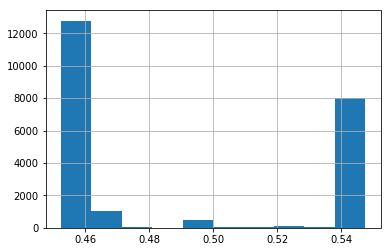

In [39]:
pd.Series(pred_y_xgb_proba[:, 1]).hist()


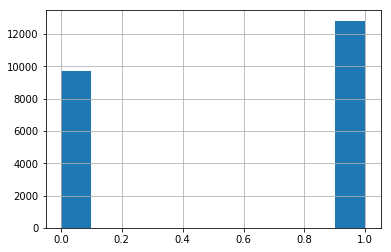

In [40]:
test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1).hist()

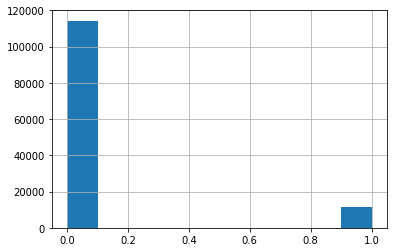

In [9]:
pd.Series(rand_forest_mdl.predict_proba(train_processed_selectedFeatures.drop(['labelsMapped'], 1))[:, 1]).hist()

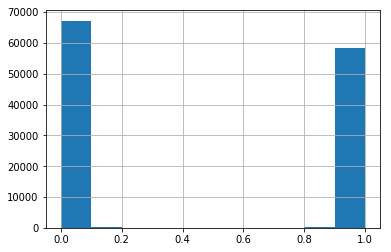

In [25]:
temp = pd.Series(rand_forest_mdl.predict_proba(train_processed_selectedFeatures.drop(['labelsMapped'], 1))[:, 1])
fig, ax = plt.subplots()
temp.hist()
ax.set_yscale('linear')

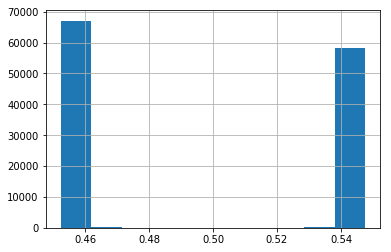

In [26]:
temp = pd.Series(mdl_xgb_binary.predict_proba(train_processed_selectedFeatures.drop(['labelsMapped'], 1))[:, 1])
fig, ax = plt.subplots()
temp.hist()
ax.set_yscale('linear')


In [19]:
temp.min()

0.0